# Bayesian Optimization in higher dimensions

In 1 dimension, random sampling is likely to perform basically as well as Bayesian optimization. Where BO really shines is when this function is multi-dimensional, corresponding to multiple parameters being optimized. 

We optimize the synthetic Hartmann6 test function, representing our unknown response curve. The standard problem is

$$f(x) = -\sum_{i=1}^4 \alpha_i \exp \left( -\sum_{j=1}^6 A_{ij} (x_j - P_{ij})^2  \right)$$

over $x \in [0,1]^6$ (parameter values can be found in `botorch/test_functions/hartmann6.py`).

Since botorch assumes a maximization problem, we will attempt to maximize $-f(x)$ to achieve $\max_{x} -f(x) = 3.32237$.

Note that in this implementation, and we suggest all implementations, parameters are modified to lie in the [0,1] range!

In [1]:
import numpy as np
import sys,os
import numpy.random as rand
from tqdm import trange
import torch
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt

from botorch.models import SingleTaskGP
from gpytorch.mlls.sum_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model


sys.path.append('../Code/BoTorch/')
from bayesOptModel import BasicBayesOpt

rand.seed(1993)

## We now define our model "System"

true_response_curve - a function that takes parameters as input and returns a noise-free observation of patient response (negative Hartman function)


In [2]:
from botorch.test_functions import Hartmann


neg_hartmann6 = Hartmann(negate=True)

def true_response_curve(parameters):
    '''
    Given parameter choice, the true response curve is noise_free_response.
    '''
    noise_free_response = neg_hartmann6(torch.from_numpy(parameters))
    return noise_free_response.numpy()


response_noise_se = 0.5 # The noise we expect in the tuning curve
def Synthetic_experiment(parameters):
    '''
    We stimulate X and observe a noisy response Y from the patient.
    '''
    true_response = true_response_curve(parameters) 
    observed_response = true_response + rand.randn(len(parameters))*response_noise_se
    return observed_response
    

## Initial observations

We now start our scientific experiment. We will stimulate 16 times at "random" locations to provide an evenly spaced estimate of the surrogate model.

Note that we start with a Sobol sampler rather than true random samples. These are random but allow for a more even spacing of the space. It should always be done as a power of two. For more information see

https://en.wikipedia.org/wiki/Sobol_sequence

An example of how this is done is shown below

In [3]:
number_initial_samples = 2**4 # 16
parameter_dimension = 6
sampler = Sobol(parameter_dimension) 

intial_parameter_values = sampler.random(number_initial_samples) # Our initial parameters
initial_responses = Synthetic_experiment(intial_parameter_values)

## We now perform our scientific experiment.

We compare two experimental designs. The first is to randomly choose parameter values and stimulate. We compare what happens when the experimenter uses the best observed value as choice vs best noise-free value.

The second is to use Bayesian optimization to inform our decision on where to stimulate. In both cases we choose the same number of tests to perform. In both cases we will compare how well the chosen optimum performs with regards to the true tuning curve.

In both cases we also record 5 patients to see credible intervals of performance

In [4]:
number_of_tests = 50
number_of_patients = 35

### Random design

In [5]:
random_true_optimum = np.zeros((number_of_patients,number_of_tests))
random_empirical_optimum = np.zeros((number_of_patients,number_of_tests))
random_surrogate_optimum = np.zeros((number_of_patients,number_of_tests))

for patient_id in range(number_of_patients):
    print('Experiment for patient %d'%patient_id)
    patient_initial_parameter_values = sampler.random(number_initial_samples)
    patient_initial_responses = Synthetic_experiment(patient_initial_parameter_values)
    
    patient_parameter_values = patient_initial_parameter_values.copy()
    patient_responses = patient_initial_responses.copy()
        
    for experiment_id in trange(number_of_tests):
        # Choose parameters
        parameters_random = rand.uniform(low=0,high=1,size=(1,parameter_dimension))
        
        # Observe response
        patient_response_random = Synthetic_experiment(parameters_random)
        
        # Add to list of experiments and results
        patient_parameter_values = np.vstack((patient_parameter_values,parameters_random))
        patient_responses = np.append(patient_responses,patient_response_random)
                        
        # Ask God what the true response was
        patient_true_responses = true_response_curve(patient_parameter_values)
        
        # Learn a surrogate model
        
        ppv_t = torch.from_numpy(patient_parameter_values)
        ppr_t = torch.from_numpy(np.atleast_2d(patient_responses).T)
        surrogate_model = SingleTaskGP(ppv_t,ppr_t)
        mll = ExactMarginalLogLikelihood(surrogate_model.likelihood,surrogate_model)
        fit_gpytorch_model(mll)
        random_points = sampler.random(1024)
        random_true = true_response_curve(random_points)
        posterior = surrogate_model.posterior(torch.from_numpy(random_points))
        post_mean = posterior.mean.detach().numpy()
        maximum_surrogate_value_location = np.argmax(post_mean)
        random_surrogate_optimum[patient_id,experiment_id] = random_true[maximum_surrogate_value_location]
        
        
        maximum_obs_value_location = np.argmax(patient_responses)
        maximum_true_value_location = np.argmax(patient_true_responses)

        random_true_optimum[patient_id,experiment_id] = patient_true_responses[maximum_true_value_location]
        random_empirical_optimum[patient_id,experiment_id] = patient_true_responses[maximum_obs_value_location]  

Experiment for patient 0


  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/austin/anaconda3/envs/botorch/lib/python3.10/site-packages/gpytorch/lazy/lazy_tensor.py:1741: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755832681/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution
100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.93it/s]


Experiment for patient 1


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.26it/s]


Experiment for patient 2


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.79it/s]


Experiment for patient 3


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.31it/s]


Experiment for patient 4


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.73it/s]


Experiment for patient 5


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.10it/s]


Experiment for patient 6


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.97it/s]


Experiment for patient 7


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.20it/s]


Experiment for patient 8


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.48it/s]


Experiment for patient 9


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.84it/s]


Experiment for patient 10


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.58it/s]


Experiment for patient 11


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.45it/s]


Experiment for patient 12


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.39it/s]


Experiment for patient 13


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.50it/s]


Experiment for patient 14


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.32it/s]


Experiment for patient 15


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.06it/s]


Experiment for patient 16


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.21it/s]


Experiment for patient 17


100%|███████████████████████████████████████████| 50/50 [00:05<00:00, 10.00it/s]


Experiment for patient 18


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 10.85it/s]


Experiment for patient 19


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.57it/s]


Experiment for patient 20


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.82it/s]


Experiment for patient 21


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.98it/s]


Experiment for patient 22


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  7.87it/s]


Experiment for patient 23


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.77it/s]


Experiment for patient 24


100%|███████████████████████████████████████████| 50/50 [00:07<00:00,  6.46it/s]


Experiment for patient 25


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.31it/s]


Experiment for patient 26


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.92it/s]


Experiment for patient 27


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.95it/s]


Experiment for patient 28


100%|███████████████████████████████████████████| 50/50 [00:06<00:00,  8.04it/s]


Experiment for patient 29


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.42it/s]


Experiment for patient 30


100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.08it/s]


Experiment for patient 31


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.90it/s]


Experiment for patient 32


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  8.86it/s]


Experiment for patient 33


100%|███████████████████████████████████████████| 50/50 [00:05<00:00,  9.43it/s]


Experiment for patient 34


100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 13.82it/s]


(16.0, 67.0)

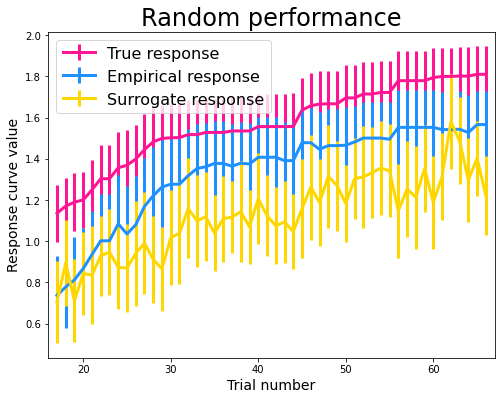

In [6]:
r_average_true_optimum = np.mean(random_true_optimum,axis=0)
r_average_empirical_optimum = np.mean(random_empirical_optimum,axis=0)
r_average_surrogate_optimum = np.mean(random_surrogate_optimum,axis=0)


def confidence_interval(y):
    return 1.96 * y.std(axis=0) / np.sqrt(number_of_patients)

r_ci_true_optimum = confidence_interval(random_true_optimum)
r_ci_empirical_optimum = confidence_interval(random_empirical_optimum)
r_ci_surrogate_optimum = confidence_interval(random_surrogate_optimum)


x = np.arange(number_of_tests) + 17

lw = 3
fs1 = 14
fs2 = 24
fs3 = 16

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(x,r_average_true_optimum,yerr=r_ci_true_optimum,
            lw=lw,c='deeppink',label='True response')
ax.errorbar(x,r_average_empirical_optimum,yerr=r_ci_empirical_optimum,
            lw=lw,c='dodgerblue',label='Empirical response')
ax.errorbar(x,r_average_surrogate_optimum,yerr=r_ci_surrogate_optimum,
            lw=lw,c='gold',label='Surrogate response')
ax.legend(loc='upper left',fontsize=fs3)
ax.set_xlabel('Trial number',fontsize=fs1)
ax.set_ylabel('Response curve value',fontsize=fs1)
ax.set_title('Random performance',fontsize=fs2)
ax.set_xlim([16,67])

Clearly the performance of random sampling is unsatisfactory. Even when we can evaluate the true response to select the best parameter value, adaquately sampling the space is so slow that even with a substantial number of trials we are far short of the true optimum. Picking the best empirical value is even worse and not guaranteed to monotonically improve. Suprisingly the surrogate value is even worse. Not sure why

### Bayesian optimization design

We use fewer patients as this is substantially slower to use 

In [7]:
number_of_tests = 50
number_of_patients = 10

The details of how to use Bayesian optimization as I implemented it can be found in the Introduction_1D notebook or in the comments of bayesianOptModel.py in the Code directory. Nevertheless I will repeat them here.

In [8]:
bounds = np.zeros((2,parameter_dimension))
model_dict = {'type':'SingleTaskGP'}
bounds[1] = 1
model = BasicBayesOpt(intial_parameter_values,np.atleast_2d(initial_responses).T,bounds,model_options=model_dict)
print(model)

BasicBayesOpt object
Version 1.2.2
Creation date 2022-05-25 14:56:46.903128
Fitted False
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
Acquisition function parameters:
type: noisy_ei
raw_samples: 512
num_candidates: 1
num_restarts: 20
>>>>>>>>>>>>>>>>>
Model parameters:
type: SingleTaskGP
sd: 0.25



In [10]:
bo_true_optimum = np.zeros((number_of_patients,number_of_tests))
bo_empirical_optimum_wrong = np.zeros((number_of_patients,number_of_tests))
bo_surrogate_optimum_wrong = np.zeros((number_of_patients,number_of_tests))

bo_empirical_optimum = np.zeros((number_of_patients,number_of_tests))
bo_surrogate_optimum = np.zeros((number_of_patients,number_of_tests))

for patient_id in range(number_of_patients):
    print('Experiment for patient %d'%patient_id)
    patient_initial_parameter_values = sampler.random(number_initial_samples)
    patient_initial_responses = Synthetic_experiment(patient_initial_parameter_values)
    
    patient_parameter_values = patient_initial_parameter_values.copy()
    patient_responses = patient_initial_responses.copy()
    
    patient_model = BasicBayesOpt(patient_parameter_values,np.atleast_2d(patient_responses).T,
                                  bounds,model_options=model_dict)
        
    for experiment_id in range(number_of_tests):
        simulation_parameters_bo = patient_model.ask()
        patient_response_bo = Synthetic_experiment(simulation_parameters_bo)
        patient_model.answer(simulation_parameters_bo,patient_response_bo)
                
        patient_true_responses = true_response_curve(patient_model.train_x)
        maximum_true_value_location = np.argmax(patient_true_responses)

        bo_true_optimum[patient_id,experiment_id] = patient_true_responses[maximum_true_value_location]
        
        params_emp,bo_empirical_optimum_wrong[patient_id,experiment_id] = patient_model.optimum(empirical=True,
                                                                                       return_y=True)
        params_sur,bo_surrogate_optimum_wrong[patient_id,experiment_id] = patient_model.optimum(return_y=True)
        
        bo_empirical_optimum[patient_id,experiment_id] = true_response_curve(params_emp)
        bo_surrogate_optimum[patient_id,experiment_id] = true_response_curve(params_sur)

Experiment for patient 0
Experiment for patient 1
Experiment for patient 2
Experiment for patient 3
Experiment for patient 4
Experiment for patient 5
Experiment for patient 6
Experiment for patient 7
Experiment for patient 8
Experiment for patient 9


(16.0, 67.0)

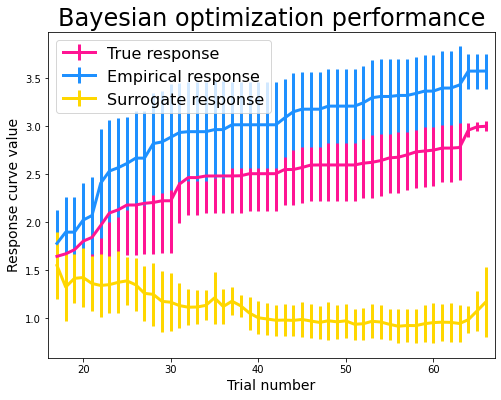

In [11]:
bo_average_true_optimum = np.mean(bo_true_optimum,axis=0)
bo_average_empirical_optimum = np.mean(bo_empirical_optimum_wrong,axis=0)
bo_average_surrogate_optimum = np.mean(bo_surrogate_optimum_wrong,axis=0)


def confidence_interval(y):
    return 1.96 * y.std(axis=0) / np.sqrt(number_of_patients)

bo_ci_true_optimum = confidence_interval(bo_true_optimum)
bo_ci_empirical_optimum = confidence_interval(bo_empirical_optimum_wrong)
bo_ci_surrogate_optimum = confidence_interval(bo_surrogate_optimum_wrong)


x = np.arange(number_of_tests) + 17

lw = 3
fs1 = 14
fs2 = 24
fs3 = 16

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(x,bo_average_true_optimum,yerr=bo_ci_true_optimum,
            lw=lw,c='deeppink',label='True response')
ax.errorbar(x,bo_average_empirical_optimum,yerr=bo_ci_empirical_optimum,
            lw=lw,c='dodgerblue',label='Empirical response')
ax.errorbar(x,bo_average_surrogate_optimum,yerr=bo_ci_surrogate_optimum,
            lw=lw,c='gold',label='Surrogate response')
ax.legend(loc='upper left',fontsize=fs3)
ax.set_xlabel('Trial number',fontsize=fs1)
ax.set_ylabel('Response curve value',fontsize=fs1)
ax.set_title('Bayesian optimization performance',fontsize=fs2)
ax.set_xlim([16,67])

There are two things to be aware of, which is why I'm including this figure. First, default options for the GP standardize the input, which is why the surrogate model response looks so weird. Secondly, if you use the empirical response you will include noise, which is why the empirical response exceeds the true maximum (3.3). Here's it done correctly.

(16.0, 67.0)

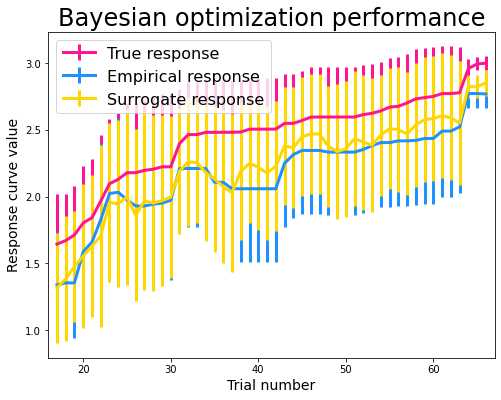

In [12]:
bo_average_true_optimum = np.mean(bo_true_optimum,axis=0)
bo_average_empirical_optimum = np.mean(bo_empirical_optimum,axis=0)
bo_average_surrogate_optimum = np.mean(bo_surrogate_optimum,axis=0)


def confidence_interval(y):
    return 1.96 * y.std(axis=0) / np.sqrt(number_of_patients)

bo_ci_true_optimum = confidence_interval(bo_true_optimum)
bo_ci_empirical_optimum = confidence_interval(bo_empirical_optimum)
bo_ci_surrogate_optimum = confidence_interval(bo_surrogate_optimum)


x = np.arange(number_of_tests) + 17

lw = 3
fs1 = 14
fs2 = 24
fs3 = 16

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(x,bo_average_true_optimum,yerr=bo_ci_true_optimum,
            lw=lw,c='deeppink',label='True response')
ax.errorbar(x,bo_average_empirical_optimum,yerr=bo_ci_empirical_optimum,
            lw=lw,c='dodgerblue',label='Empirical response')
ax.errorbar(x,bo_average_surrogate_optimum,yerr=bo_ci_surrogate_optimum,
            lw=lw,c='gold',label='Surrogate response')
ax.legend(loc='upper left',fontsize=fs3)
ax.set_xlabel('Trial number',fontsize=fs1)
ax.set_ylabel('Response curve value',fontsize=fs1)
ax.set_title('Bayesian optimization performance',fontsize=fs2)
ax.set_xlim([16,67])

Surprisingly empirical is better than using the surrogate, very surprising to me not sure why

## We now compare the performance of the two

(16.0, 67.0)

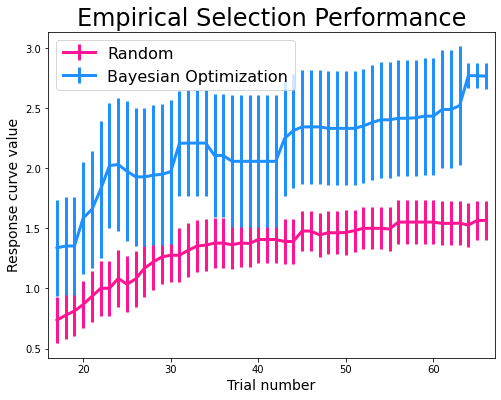

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(x,r_average_empirical_optimum,yerr=r_ci_empirical_optimum,
            lw=lw,c='deeppink',label='Random')
ax.errorbar(x,bo_average_empirical_optimum,yerr=bo_ci_empirical_optimum,
            lw=lw,c='dodgerblue',label='Bayesian Optimization')
ax.legend(loc='upper left',fontsize=fs3)
ax.set_xlabel('Trial number',fontsize=fs1)
ax.set_ylabel('Response curve value',fontsize=fs1)
ax.set_title('Empirical Selection Performance',fontsize=fs2)
ax.set_xlim([16,67])

# Summary

Bayesian optimization can really shine in high-dimensional parameter spaces as the "volume" of the space makes random sampling highly inefficient. Furthermore, without knowing the true tuning curve using the best empirical value can give erronius results.